In [1]:
import jax 
import jax.numpy as jnp

x0 = [0.1, 0.1]
y = [1.8, 0.2]
T = 3.0
M = 600

In [2]:
from experiments import plotting


def mean_and_std(trajs):
    mean = jnp.mean(trajs, axis=0)
    std = jnp.std(trajs, axis=0)
    return mean, std


def plot_mean_and_std(mean, std, ts, ax, fig, axs):
    axs.plot(ts, mean[:, ax])
    axs.fill_between(ts, mean[:, ax] - std[:, ax], mean[:, ax] + std[:, ax], alpha=0.5)
    return fig, axs


Load unconditioned trajectories

In [3]:
from src.sdes import sde_cell_model

fw_N = 1000
data_fn  = sde_cell_model.data_forward(x0, T, fw_N)
keys = jax.random.split(jax.random.PRNGKey(10), 1000)

ts_mult, forward_trajs, _ = data_fn(keys)
ts = ts_mult[0, :, 0]



Load conditioned trajectories from proposed model

In [4]:
from src.sdes import sde_cell_model
from src.sdes import sde_utils
import functools


path = f"../../checkpoints/cell/fixed_y_{y}_T_{T}_N_{M}"
trained_score, restored = plotting.load_checkpoint_without_batch_stats(path)

def conditioned_fn(key, ts_cond):
    drift, diffusion = sde_cell_model.vector_fields()
    traj = sde_utils.conditioned(key, ts_cond, x0, trained_score, drift, diffusion)
    return traj

keys = jax.random.split(jax.random.PRNGKey(20), 1000)

ts_cond_10 = jnp.linspace(0, T, 10)
ts_cond_50 = jnp.linspace(0, T, 50)
ts_cond_100 = jnp.linspace(0, T, 100)
# ts_cond_1000 = jnp.linspace(0, T, 1000)

cond_10 = jax.vmap(functools.partial(conditioned_fn, ts_cond=ts_cond_10))(keys)
cond_50 = jax.vmap(functools.partial(conditioned_fn, ts_cond=ts_cond_50))(keys)
cond_100 = jax.vmap(functools.partial(conditioned_fn, ts_cond=ts_cond_100))(keys)
# cond_1000 = jax.vmap(functools.partial(conditioned_fn, ts_cond=ts_cond_1000))(keys)

Load time reversed trajectories from diffusion bridge

In [5]:
import numpy as np

db_10 = np.load(f"/Users/libbybaker/Documents/Python/DiffusionBridge/cell/cell_traj_T_3.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.8000, 0.2000])_M_{M}_10.npy")

db_50 = np.load(f"/Users/libbybaker/Documents/Python/DiffusionBridge/cell/cell_traj_T_3.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.8000, 0.2000])_M_{M}_50.npy")

db_100 = np.load(f"/Users/libbybaker/Documents/Python/DiffusionBridge/cell/cell_traj_T_3.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.8000, 0.2000])_M_{M}_100.npy")

# db_1000 = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/cell/cell_traj_T_3.0_X0_tensor([0.1000, 0.1000])_XT_tensor([1.8000, 0.2000])_M_600_1000.npy")

time_10 = db_10.shape[1]
time_50 = db_50.shape[1]
time_100 = db_100.shape[1]
# time_1000 = db_1000.shape[1]

ts_10 = np.linspace(0, T, time_10)
ts_50 = np.linspace(0, T, time_50)
ts_100 = np.linspace(0, T, time_100)
# ts_1000 = np.linspace(0, T, time_1000)

Plot everything

In [6]:
import matplotlib.pyplot as plt
from tueplots import bundles, axes, cycler, figsizes
from tueplots.constants.color import palettes

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))
plt.rcParams.update(axes.lines())


def plot_trajectories(trajs, ts, axis, axs, color, **plot_kwargs):
    for traj in trajs:
        axs.plot(ts, traj[:, axis], color=color, **plot_kwargs)
    return axs

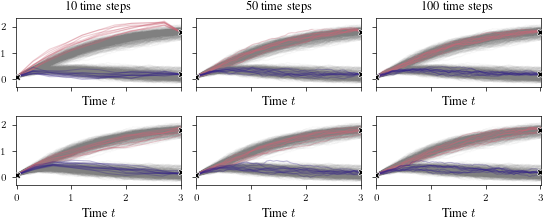

In [7]:
plt.rcParams.update(figsizes.neurips2023(nrows=2, ncols=3))

num_trajs_plt = 10

fig, axs = plt.subplot_mosaic([["forward_10", "forward_50", "forward_100"],
                               ["cond_10", "cond_50", "cond_100"]], sharex=True, sharey=True)

upper_max = 2.3
upper_min = 1.5
lower_max = 0.5
lower_min = -1.0

plot_kwargs_true = {"linewidth": 0.8, "alpha": 0.05}
plot_kwargs = {"linewidth": 0.8, "alpha": 0.3}


# for ax in axs["forward_10"], axs["forward_30"], axs["forward_100"], axs["forward_1000"]:
for _, ax in axs.items():
    
    for traj in forward_trajs[:1000]:
        if traj[-1, 0] > upper_min and lower_min < traj[-1, 1] < lower_max:
            ax.plot(ts, traj[:, 0], color='grey', **plot_kwargs_true)
            ax.plot(ts, traj[:, 1], color='grey', **plot_kwargs_true)
        if traj[-1, 1] > upper_min and lower_min < traj[-1, 0] < lower_max:
            ax.plot(ts, traj[:, 1], color='grey', **plot_kwargs_true)
            ax.plot(ts, traj[:, 0], color='grey', **plot_kwargs_true)
            
    ax.set_xlim(-0.01, 3.01)
    ax.set_xlabel("Time $t$")
    ax.plot([0, 3, 3], [0.1, 1.8, 0.2], marker="X",markersize=5, markeredgewidth=0.5, linestyle="None", zorder=10, color="black", markeredgecolor="white")

axs["forward_10"] = plot_trajectories(db_10[:num_trajs_plt], ts_10, 0, axs["forward_10"], 'C0', **plot_kwargs)
axs["forward_10"] = plot_trajectories(db_10[:num_trajs_plt], ts_10, 1, axs["forward_10"], 'C1', **plot_kwargs)
axs["forward_10"].set_title("10 time steps")

axs["forward_50"] = plot_trajectories(db_50[:num_trajs_plt], ts_50, 0, axs["forward_50"], 'C0', **plot_kwargs)
axs["forward_50"] = plot_trajectories(db_50[:num_trajs_plt], ts_50, 1, axs["forward_50"], 'C1', **plot_kwargs)
axs["forward_50"].set_title("50 time steps")

axs["forward_100"] = plot_trajectories(db_100[:num_trajs_plt], ts_100, 0, axs["forward_100"], 'C0', **plot_kwargs)
axs["forward_100"] = plot_trajectories(db_100[:num_trajs_plt], ts_100, 1, axs["forward_100"], 'C1', **plot_kwargs)
axs["forward_100"].set_title("100 time steps")

# axs["forward_1000"] = plot_trajectories(db_1000[:num_trajs_plt], ts_1000, 0, axs["forward_1000"], 'C0', **plot_kwargs)
# axs["forward_1000"] = plot_trajectories(db_1000[:num_trajs_plt], ts_1000, 1, axs["forward_1000"], 'C1', **plot_kwargs)
# axs["forward_1000"].set_title("1000")

axs["cond_10"] = plot_trajectories(cond_10[:num_trajs_plt], ts_cond_10, 0, axs["cond_10"], 'C0', **plot_kwargs)
axs["cond_10"] = plot_trajectories(cond_10[:num_trajs_plt], ts_cond_10, 1, axs["cond_10"], 'C1', **plot_kwargs)
# axs["cond_10"].set_title("10 time steps")

axs["cond_50"] = plot_trajectories(cond_50[:num_trajs_plt], ts_cond_50, 0, axs["cond_50"], 'C0', **plot_kwargs)
axs["cond_50"] = plot_trajectories(cond_50[:num_trajs_plt], ts_cond_50, 1, axs["cond_50"], 'C1', **plot_kwargs)
# axs["cond_50"].set_title("50 time steps")

axs["cond_100"] = plot_trajectories(cond_100[:num_trajs_plt], ts_cond_100, 0, axs["cond_100"], 'C0', **plot_kwargs)
axs["cond_100"] = plot_trajectories(cond_100[:num_trajs_plt], ts_cond_100, 1, axs["cond_100"], 'C1', **plot_kwargs)
# axs["cond_100"].set_title("100 time steps")

# axs["cond_1000"] = plot_trajectories(cond_1000[:num_trajs_plt], ts_cond_1000, 0, axs["cond_1000"], 'C0', **plot_kwargs)
# axs["cond_1000"] = plot_trajectories(cond_1000[:num_trajs_plt], ts_cond_1000, 1, axs["cond_1000"], 'C1', **plot_kwargs)
# axs["cond_1000"].set_title("1000")


plt.savefig("convergence_db.pdf")


In [8]:
assert False

AssertionError: 